In [2]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import warnings
warnings.filterwarnings("ignore")

In [3]:
# axis_font = {'fontname':'Arial', 'size':'14'}
axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

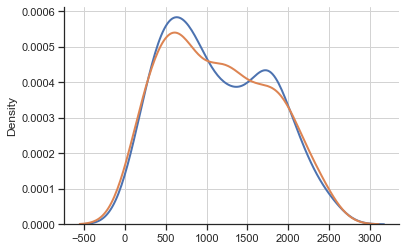

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

# X, y, features, categ, sch_nan = ds.load_actg_dataset()
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
# X, y, features, categ, sch_nan = ds.load_wuhan_dataset()

qs = np.quantile(y["time"], np.linspace(0.2, 0.8, 4))
time_discr = np.searchsorted(qs, y["time"])

discr = np.char.add(time_discr.astype(str), y["cens"].astype(str))
X_TR, X_HO = train_test_split(X, stratify=discr, test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

df_tr = X_tr.copy()
df_tr["time"] = y_tr["time"]
df_tr["cens"] = y_tr["cens"]

sns.kdeplot(y_tr["time"], label="train")
sns.kdeplot(y_HO["time"], label="HO")
plt.show()

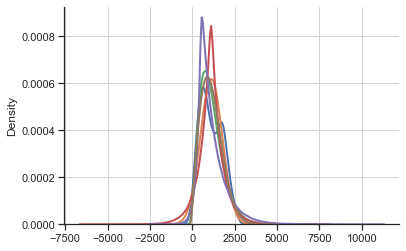

In [21]:
import scipy.stats as stats

sns.kdeplot(y_tr["time"])
for st in [stats.norm, stats.gamma, stats.laplace, stats.laplace_asymmetric, stats.rayleigh]:
    params = st.fit(df["time"])
    sns.kdeplot(st.rvs(*params, size=1000000, random_state=42))

### Informative censuring comparison

In [23]:
from survivors.external.nonparametric import KaplanMeier

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
bins_HO = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

df = X.copy()
df["time"] = y["time"]
df["cens"] = y["cens"]

SF IBS:0.17723, AUPRC:0.28175
SF1 IBS:0.18428, AUPRC:0.32687


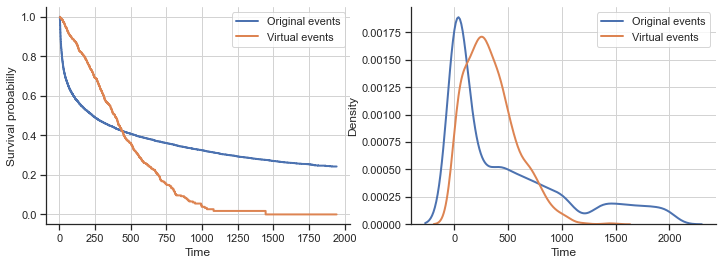

In [51]:
def med_std(x):
    N = len(x)
    d2 = abs(x - np.median(x))**2  # abs is for complex `a`
    var = np.sum(d2) / N  # note use of `ddof`
    return var**0.5

class KaplanMeierZeroAfter(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.array(durations)
        self.events = np.array(right_censor)
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        # place_bin = np.digitize(times, self.timeline)  # -1
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf
    
class KaplanMeierZeroAfterTh(KaplanMeier):
    def __init__(self, d_type, *args, **kwargs):
        self.d_type = d_type
        super().__init__(*args, **kwargs)
        
    def fit(self, durations, right_censor, weights=None):
        params = self.d_type.fit(durations[right_censor == 1])
        self.durs = self.d_type.rvs(*params, size=1000, random_state=42)
        self.events = np.random.choice(right_censor, size=1000, replace=True)
#         self.durs = np.hstack([durations.copy(), self.durs])
#         self.events = np.hstack([right_censor.copy(), self.events])
        
        self.events = self.events[self.durs > 0]
        self.durs = self.durs[self.durs > 0]
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf

y_ = y
X_ = X

km = KaplanMeierZeroAfter()
km.fit(y_["time"], y_["cens"])
sf = km.survival_function_at_times(bins_HO)

km1 = KaplanMeierZeroAfterTh(stats.norm)
km1.fit(y_["time"], y_["cens"])
sf1 = km1.survival_function_at_times(bins_HO)

ibs_sf = metr.ibs_remain(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
ibs_sf1 = metr.ibs_remain(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

auprc_sf = metr.auprc(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
auprc_sf1 = metr.auprc(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].step(bins_HO, sf, label="Original events")
axes[0].step(bins_HO, sf1, label="Virtual events")
axes[0].legend()

sns.kdeplot(km.durs, ax=axes[1], label="Original events")
sns.kdeplot(km1.durs, ax=axes[1], label="Virtual events")
axes[1].legend()

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Survival probabilily")
axes[1].set_xlabel("Time")
print(f"SF IBS:{ibs_sf:.5f}, AUPRC:{auprc_sf:.5f}")
print(f"SF1 IBS:{ibs_sf1:.5f}, AUPRC:{auprc_sf1:.5f}")

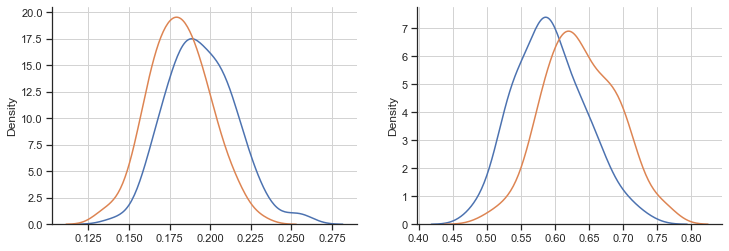

0.1944&0.1809&3.502e-06
0.5926&0.6374&7.766e-09


Text(0, 0.5, '$AUPRC$')

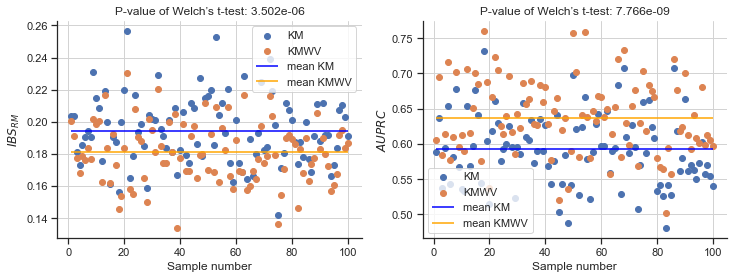

In [58]:
x = np.linspace(1, 100, 100)
ibs_1 = []
ibs_2 = []
auprc_1 = []
auprc_2 = []
np.random.seed(1)

for i, _ in enumerate(x):
    x_sub = df.sample(n=int(X.shape[0]*0.05), replace=True, random_state=i)  #  X.shape[0]*0.05, X.shape[0]*0.3
    time = x_sub["time"].to_numpy()
    cens = x_sub["cens"].to_numpy()
    
    bins_ = cnt.get_bins(time=time)
    y_v = cnt.get_y(cens=cens, time=time)
    
    km = KaplanMeierZeroAfter()
    km.fit(y_v["time"], y_v["cens"])
    sf = km.survival_function_at_times(bins_)

    km1 = KaplanMeierZeroAfter1()
    km1.fit(y_v["time"], y_v["cens"])
    sf1 = km1.survival_function_at_times(bins_)

    ibs_1.append(metr.ibs_remain(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    ibs_2.append(metr.ibs_remain(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

    auprc_1.append(metr.auprc(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    auprc_2.append(metr.auprc(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(ibs_1, ax=axes[0])
sns.kdeplot(ibs_2, ax=axes[0])

sns.kdeplot(auprc_1, ax=axes[1])
sns.kdeplot(auprc_2, ax=axes[1])
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(x, ibs_1, label="KM")
axes[0].scatter(x, ibs_2, label="KMWV")
axes[0].hlines([np.mean(ibs_1)], xmin=min(x), xmax=max(x), color="blue", label="mean KM")
axes[0].hlines([np.mean(ibs_2)], xmin=min(x), xmax=max(x), color="orange", label="mean KMWV")
axes[0].set_title(f"P-value of Welch’s t-test: {stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")
axes[0].legend()
axes[0].set_xlabel("Sample number")
axes[0].set_ylabel(r"$IBS_{RM}$")
print(f"{np.mean(ibs_1):.4f}&{np.mean(ibs_2):.4f}&{stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")

axes[1].scatter(x, auprc_1, label="KM")
axes[1].scatter(x, auprc_2, label="KMWV")
axes[1].hlines([np.mean(auprc_1)], xmin=min(x), xmax=max(x), color="blue", label="mean KM")
axes[1].hlines([np.mean(auprc_2)], xmin=min(x), xmax=max(x), color="orange", label="mean KMWV")
axes[1].set_title(f"P-value of Welch’s t-test: {stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")
print(f"{np.mean(auprc_1):.4f}&{np.mean(auprc_2):.4f}&{stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")
axes[1].legend()

axes[1].set_xlabel("Sample number")
axes[1].set_ylabel(r"$AUPRC$")

In [ ]:
0.1723&0.1660&6.324e-31
0.2819&0.3215&1.354e-114

0.1723&0.1934&4.333e-100
0.2819&0.3583&2.760e-139

In [31]:
stats.norm._ctor_param["name"]

'norm'

In [55]:
def print_metric_by_nonparam(df, subsample=0.3, prefix=""):
    ibs_1 = []
    ibs_2 = []
    auprc_1 = []
    auprc_2 = []
    np.random.seed(1)
    
    d = {}
    for i, _ in enumerate(np.linspace(1, 100, 100)):
        x_sub = df.sample(n=int(X.shape[0]*subsample), replace=True, random_state=i)  #  X.shape[0]*0.05, X.shape[0]*0.3
        time = x_sub["time"].to_numpy()
        cens = x_sub["cens"].to_numpy()

        bins_ = cnt.get_bins(time=time)
        y_v = cnt.get_y(cens=cens, time=time)
        
        for th in ["", stats.norm, stats.gamma, stats.laplace, stats.laplace_asymmetric, stats.rayleigh]:
            if th != "":
                suff = th._ctor_param["name"]
                km = KaplanMeierZeroAfterTh(th)
            else:
                suff = "km"
                km = KaplanMeierZeroAfter()
            km.fit(y_v["time"], y_v["cens"])
            sf = km.survival_function_at_times(bins_)
            
            ibs_ = metr.ibs_remain(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_)
            auprc_ = metr.auprc(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_)
            if suff+"IBS" in d:
                d[suff+"IBS"].append(ibs_)
            else:
                d[suff+"IBS"] = [ibs_]
            if suff+"AUPRC" in d:
                d[suff+"AUPRC"].append(auprc_)
            else:
                d[suff+"AUPRC"] = [auprc_]
    
    d_ = {k: np.mean(v) for k, v in d.items()}
    d_["dataset"] = prefix
    d_["subsample"] = subsample
    return d_

#     print(f"{prefix + '|'}IBS:({subsample}): {np.mean(ibs_1):.4f}&{np.mean(ibs_2):.4f}&{stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")
#     print(f"{prefix + '|'}AUPRC({subsample}): {np.mean(auprc_1):.4f}&{np.mean(auprc_2):.4f}&{stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")

In [56]:
from survivors.datasets import DATASETS_LOAD

l = []
for ds_name in ["GBSG", "PBC", "WUHAN", "rott2", "smarto", "support2"]:
    X, y, features, categ, sch_nan = DATASETS_LOAD[ds_name]()
    bins_HO = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

    df = X.copy()
    df["time"] = y["time"]
    df["cens"] = y["cens"]
    d = print_metric_by_nonparam(df, subsample=0.3, prefix=ds_name)
    l.append(d)
    d = print_metric_by_nonparam(df, subsample=0.05, prefix=ds_name)
    l.append(d)

df_res = pd.DataFrame(l).T

In [57]:
# Terminal events
pd.DataFrame(l).T

,0,1,2,3,4,5,6,7,8,9,10,11
kmIBS,0.185617,0.194361,0.196099,0.209545,0.193102,0.211633,0.170781,0.186488,0.205327,0.199643,0.172317,0.172573
kmAUPRC,0.593726,0.592633,0.605603,0.630119,0.569368,0.565122,0.597455,0.589627,0.843064,0.847603,0.281913,0.283134
normIBS,0.159763,0.182489,0.16544,0.197108,0.151331,0.20643,0.126943,0.14643,0.16703,0.163042,0.177834,0.178473
normAUPRC,0.642917,0.63574,0.653491,0.650374,0.604741,0.588258,0.639133,0.635284,0.856325,0.857527,0.327942,0.327291
gammaIBS,0.158839,0.18822,0.173486,0.212239,0.161459,0.225106,0.129675,0.149177,0.191369,0.178866,0.169114,0.16904
gammaAUPRC,0.620339,0.590159,0.583092,0.583394,0.516687,0.524896,0.618585,0.60707,0.821854,0.822379,0.276876,0.276967
laplaceIBS,0.163652,0.184639,0.166899,0.196521,0.152247,0.204025,0.130664,0.150905,0.175138,0.170356,0.181244,0.181882
laplaceAUPRC,0.618652,0.613991,0.626072,0.632345,0.573413,0.564836,0.612933,0.609973,0.847283,0.846843,0.292836,0.293158
laplace_asymmetricIBS,0.160387,0.180083,0.170632,0.194493,0.151844,0.202535,0.135272,0.15187,0.18659,0.176954,0.178548,0.179289
laplace_asymmetricAUPRC,0.607816,0.616298,0.601432,0.639807,0.559471,0.573091,0.590644,0.592385,0.830867,0.83996,0.294188,0.294204


In [74]:
# IBS growth
1 - df_res.T.iloc[:-2:2] / df_res.T.iloc[[0]].values

,0,1,2,3,4,5,6,7,8,9,10,11
kmIBS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
normIBS,0.139284,0.061081,0.156343,0.059356,0.216315,0.024585,0.256691,0.214803,0.186515,0.183331,-0.032017,-0.034185
gammaIBS,0.144265,0.031595,0.115313,-0.012855,0.163863,-0.06366,0.24069,0.200072,0.067978,0.104073,0.018585,0.020473
laplaceIBS,0.118336,0.050022,0.148901,0.062154,0.211572,0.035949,0.234899,0.190807,0.14703,0.146698,-0.051805,-0.053941
laplace_asymmetricIBS,0.135924,0.073459,0.129868,0.071833,0.213658,0.042991,0.20792,0.185633,0.091253,0.113649,-0.036161,-0.038917
rayleighIBS,0.138872,0.064921,0.159723,0.062602,0.223398,0.034921,0.254948,0.212732,0.197035,0.178531,-0.034791,-0.037867


In [73]:
# AUPRC growth
df_res.T.iloc[1:-2:2] / df_res.T.iloc[[1]].values - 1

,0,1,2,3,4,5,6,7,8,9,10,11
kmAUPRC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
normAUPRC,0.082851,0.072737,0.079075,0.032144,0.062128,0.040941,0.069759,0.077434,0.01573,0.011708,0.163275,0.155958
gammaAUPRC,0.044823,-0.004175,-0.037171,-0.074153,-0.092526,-0.07118,0.035365,0.029584,-0.025157,-0.029759,-0.017864,-0.021781
laplaceAUPRC,0.041983,0.036039,0.033799,0.003532,0.007104,-0.000506,0.025906,0.034508,0.005005,-0.000897,0.038749,0.035402
laplace_asymmetricAUPRC,0.023732,0.039931,-0.006887,0.015375,-0.017381,0.014102,-0.011401,0.004678,-0.014467,-0.009017,0.043542,0.039095
rayleighAUPRC,0.071865,0.063616,0.056221,0.015361,0.042167,0.024731,0.051113,0.055864,0.008115,0.00448,0.140649,0.135665
